# Example: Human segmentation with attention U-net and transfer learning from ImageNet-trained VGG16 model

In [14]:
import numpy as np
from glob import glob

In [15]:
from tensorflow import keras

In [4]:
#!pip install keras-unet-collection

  Using cached keras_unet_collection-0.1.11-py3-none-any.whl (67 kB)


This example requires `keras-unet-collection`:
```
pip install keras-unet-collection
```

In [16]:
from keras_unet_collection import models, utils

In [17]:
import tensorflow as tf
print(tf.__version__)

2.5.0


In [45]:
# the indicator of a fresh run
FIRST_TIME_RUNNING = False

# user-specified working directory
FILE_PATH = 'dataset/'
FILE_PATH_LABEL = 'dataset/'

## The Monuseg dataset

The dataset for this challenge was obtained by carefully annotating tissue images of several patients with tumors of different organs and who were diagnosed at multiple hospitals. This dataset was created by downloading H&E stained tissue images captured at 40x magnification from TCGA archive. 

H&E staining is a routine protocol to enhance the contrast of a tissue section and is commonly used for tumor assessment (grading, staging, etc.). 

Given the diversity of nuclei appearances across multiple organs and patients, and the richness of staining protocols adopted at multiple hospitals, the training datatset will enable the development of robust and generalizable nuclei segmentation techniques that will work right out of the box.

In [ ]:
''' 

# downloading and executing data files
if FIRST_TIME_RUNNING:
    import zipfile
    import urllib.request
    import subprocess
    local_names = ['train2017.zip', 'val2017.zip', 'stuffthingmaps_trainval2017.zip']
    urls = ['http://images.cocodataset.org/zips/train2017.zip', 
            'http://images.cocodataset.org/zips/val2017.zip', 
            'http://calvin.inf.ed.ac.uk/wp-content/uploads/data/cocostuffdataset/stuffthingmaps_trainval2017.zip']
    
    for i, local_name in enumerate(local_names):
        
        print("Accessing <{}>".format(local_name))
        filename = FILE_PATH + local_name
        
        # calvin group labels
        if i == 2:
            subprocess.Popen(['wget', '-O', filename, urls[i]]) # <--- wget
            with zipfile.ZipFile(filename, 'r') as zip_io:
                zip_io.extractall(FILE_PATH_LABEL) 
        # coco train/val images
        else:
            urllib.request.urlretrieve(urls[i], filename);    
            with zipfile.ZipFile(filename, 'r') as zip_io:
                zip_io.extractall(FILE_PATH)
                
'''

In [46]:
# train files path
path_train_img = FILE_PATH + 'train folder/img/'
path_val_mask = FILE_PATH_LABEL + 'train folder/mask/'

# validation file path 
path_valid_img = FILE_PATH + 'validation folder/img/'
path_valid_mask = FILE_PATH_LABEL + 'validation folder/mask/'

# test files path
path_test_img = FILE_PATH + 'test folder/img/'
path_test_mask = FILE_PATH_LABEL + 'test folder/mask/'



### Subsetting human samples

For obtaining a better focus of the segmentation target, human samples are subsetted from COCO.

The selection criteria is that after resizing to 128-by-128, human samples should have more than 33% of its 64-by-64 central pixels belong to the human/person category.

As a binary segmentation problem, non-human COCO-stuff labels are grouped and labelled as "background". Accessory categories (e.g., ties) are also grouped into the background.

**Note**: sample subsetting code cells are time-consuming.

In [ ]:

#def split_human_samples(label_filenames, human_id=0, human_rate=1/3):
    '''
    Subsetting samples that contain "person/human" category from the COCO dataset
    ----------
    human_id = 0 : COCO stuffthingmaps label human as int 0
    human_rate = 1/3: at least 33% of the pixels should belong to human.
    ----------
    '''
    '''
    thres = int(64*64*human_rate)   # pixel number thres after resizing
    label_len = len(label_filenames)
    flag = []   # return a list of booleans
    for i in range(label_len):
        sample_ = utils.image_to_array([label_filenames[i]], size=128, channel=1)
        if np.sum(sample_[0, 32:-32, 32:-32, 0] == human_id) > thres:
            flag.append(True)
        else:
            flag.append(False)
        return flag
    '''

In [47]:
train_input_names = np.array(sorted(glob(path_train_img+'*.png')))
train_label_names = np.array(sorted(glob(path_val_mask+'*.png')))
#flag_human = split_human_samples(train_label_names, human_id=0)
#train_input_names = train_input_names[flag_human]
#train_label_names = train_label_names[flag_human]

In [48]:
test_input_names = np.array(sorted(glob(path_test_img+'*.png')))
test_label_names = np.array(sorted(glob(path_test_mask+'*.png')))
#flag_human_test = split_human_samples(test_label_names, human_id=0)
#test_input_names = test_input_names[flag_human_test]
#test_label_names = test_label_names[flag_human_test]

In [49]:
valid_input_names = np.array(sorted(glob(path_valid_img+'*.png')))
valid_label_names = np.array(sorted(glob(path_valid_mask+'*.png')))

### Training-validation data split

The COCO validation samples are treated as testing sets.

The validation data of this example is split form the COCO training samples. 

In [60]:

L = len(train_input_names)
ind_all = utils.shuffle_ind(L)

L_train = int(0.9*L); L_valid = L - L_train
ind_train = ind_all[:L_train]; ind_valid = ind_all[L_train:]
'''
train_input_names = train_input_names[ind_train]
train_label_names = train_label_names[ind_train]
valid_input_names = train_input_names[ind_valid]
valid_label_names = train_label_names[ind_valid]

print("Training:validation:testing = {}:{}:{}".format(L_train, L_valid, len(test_label_names
'''

'\ntrain_input_names = train_input_names[ind_train]\ntrain_label_names = train_label_names[ind_train]\nvalid_input_names = train_input_names[ind_valid]\nvalid_label_names = train_label_names[ind_valid]\n\nprint("Training:validation:testing = {}:{}:{}".format(L_train, L_valid, len(test_label_names\n'

### Exploratory data analysis

In [50]:
import matplotlib.pyplot as plt
%matplotlib inline

def ax_decorate_box(ax):
    [j.set_linewidth(0) for j in ax.spines.values()]
    ax.tick_params(axis="both", which="both", bottom=False, top=False, \
               labelbottom=False, left=False, right=False, labelleft=False)
    return ax

In [51]:
I_MAX = 10   # explore 10 images
input_example = utils.image_to_array(train_input_names[:I_MAX], size=128, channel=3)
label_example = utils.image_to_array(train_label_names[:I_MAX], size=128, channel=1)

Text(0.5, 1.0, 'Segmentation mask')

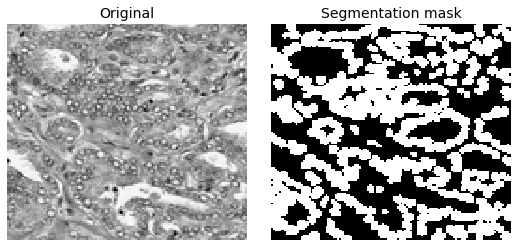

In [53]:
i_example = 2

fig, AX = plt.subplots(1, 2, figsize=(7, 3))
plt.subplots_adjust(0, 0, 1, 1, hspace=0, wspace=0.1)

for ax in AX:
    ax = ax_decorate_box(ax)
AX[0].pcolormesh(np.mean(input_example[i_example, ...], axis=-1), cmap=plt.cm.gray)
AX[1].pcolormesh(label_example[i_example, ..., 0] > 0, cmap=plt.cm.gray)
AX[0].set_title("Original", fontsize=14)
AX[1].set_title("Segmentation mask", fontsize=14)

## Attention U-net with an ImageNet-trained backbone

Attention U-net is applied for this segmentation task. This architecture is modified from the conventionally used U-net by assigning attention gates on each upsampling level. 

Attention gates take upsampled (i.e., decoded) and downsampled (i.e., encoded) tensors as queries and keys, respectively. These queries and keys are mapped to intermediate channel sizes and fed into the additive attention learning. The resulting vector is rescaled by a sigmoid function and multiplied with the downsampled tensor (keys, but here treated as "values" of self-attention). The attention gate output replaces the downsampled tensor and is concatenated with the upsampled tensor.

Based on the amount and complexity of COCO samples, ImageNet-trained VGG16 is applied as an encoder backbone. This transfer learning strategy is expected to improve the segmentation performance based on two reasons: 

 * The ImageNet and COCO containts (somewhat) similar kinds of natural images with a high overlap of data distribution; 

 * The VGG16 architecture is a combination of same-padding convolution and max-pooling kernels, capable of extracting hierarchical features that can be processed by attention gates (ResNet backbone contains zero padding layers and is suboptimal in this case).

The code cell below configures the attention U-net with an ImageNet-trained VGG16 backbone. Hyper-parameters are explained through the Python helper function:

```python
from keras_unet_collection import models

help(models.att_unet_2d)
```

In [54]:
model = models.att_unet_2d((128, 128, 3), filter_num=[64, 128, 256, 512, 1024], n_labels=2, 
                           stack_num_down=2, stack_num_up=2, activation='ReLU', 
                           atten_activation='ReLU', attention='add', output_activation='Sigmoid', 
                           batch_norm=True, pool=False, unpool=False, 
                           backbone='VGG16', weights='imagenet', 
                           freeze_backbone=True, freeze_batch_norm=True, 
                           name='attunet')

C:\Users\MCSP_Lab\anaconda3\envs\python 3-8\lib\site-packages\keras_unet_collection\_backbone_zoo.py:45: UserWarning: 

Backbone VGG16 does not use batch norm, but other layers received batch_norm=True
  warnings.warn(param_mismatch);


58892288/58889256 [==============================] - 6s 0us/step


The second layer of the configured model, i.e., right after an input layer, is expected to be the VGG16 backbone.

In [55]:
model.layers[1].name

'VGG16_backbone'

For simplicity, this segmentation model is trained with cross-entropy loss with SGD optimizer and a learning rate of 1E-2.

In [56]:
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.SGD(lr=1e-2))

C:\Users\MCSP_Lab\anaconda3\envs\python 3-8\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


## Training

The segmentation model is trained with 200 epoches with early stopping. Each epoch containts 100 batches and each batch contains 32 samples.

*The training process here is far from systematic, and is provided for illustration purposes only.*

In [57]:
def input_data_process(input_array):
    '''converting pixel vales to [0, 1]'''
    return input_array/255.


def target_data_process(target_array):
    '''Converting human, non-human pixels into two categories.'''
    target_array[target_array > 0] = 1  # grouping all other non-human categories 
    return keras.utils.to_categorical(target_array, num_classes=2)

In [58]:
valid_input = input_data_process(utils.image_to_array(valid_input_names, size=128, channel=3))
valid_label = target_data_process(utils.image_to_array(valid_label_names, size=128, channel=1))

In [61]:
N_EPOCH = 200  # number of epoches
N_BATCH = 100  # number of batches per epoch
N_SAMPLE = 32  # number of samples per batch

tol = 0  # current early stopping patience
max_tol = 2  # the max-allowed early stopping patience
min_del = 0  # the lowest acceptable loss value reduction 

# loop over epoches
for epoch in range(N_EPOCH):    
    # initial loss record
    if epoch == 0:
        y_pred = model.predict([valid_input])
        record = np.mean(keras.losses.categorical_crossentropy(valid_label, y_pred))
        print('\tInitial loss = {}'.format(record))
    # loop over batches
    for step in range(N_BATCH):
        # selecting smaples for the current batch
        ind_train_shuffle = utils.shuffle_ind(L_train)[:N_SAMPLE]
        
        # batch data formation
        # augmentation is not applied
        train_input = input_data_process(utils.image_to_array(train_input_names[ind_train_shuffle], size=128, channel=3))
        train_label = target_data_process(utils.image_to_array(train_label_names[ind_train_shuffle], size=128, channel=1))
        
        # train on batch
        loss_ = model.train_on_batch([train_input,], [train_label,])
        # ** training loss is not stored ** #
        
    # epoch-end validation
    y_pred = model.predict([valid_input])
    record_temp = np.mean(keras.losses.categorical_crossentropy(valid_label, y_pred))
    # ** validation loss is not stored ** #
    
    # if loss is reduced
    if record - record_temp > min_del:
        print('Validation performance is improved from {} to {}'.format(record, record_temp))
        record = record_temp;  # update the loss record
        tol = 0;  # refresh early stopping patience
        # ** model checkpoint is not stored ** #
        
    # if loss not reduced
    else:
        print('Validation performance {} is NOT improved'.format(record_temp))
        tol += 1
        if tol >= max_tol:
            print('Early stopping')
            break
        else:
            # Pass to the next epoch
            continue

	Initial loss = 0.6887639760971069
Validation performance is improved from 0.6887639760971069 to 0.5887515544891357
Validation performance is improved from 0.5887515544891357 to 0.48237746953964233
Validation performance is improved from 0.48237746953964233 to 0.4362984597682953
Validation performance is improved from 0.4362984597682953 to 0.41937345266342163
Validation performance is improved from 0.41937345266342163 to 0.41160959005355835
Validation performance is improved from 0.41160959005355835 to 0.4069672226905823
Validation performance is improved from 0.4069672226905823 to 0.40294957160949707
Validation performance is improved from 0.40294957160949707 to 0.4000653326511383
Validation performance is improved from 0.4000653326511383 to 0.3976209759712219
Validation performance is improved from 0.3976209759712219 to 0.39550477266311646
Validation performance is improved from 0.39550477266311646 to 0.3933280110359192
Validation performance is improved from 0.3933280110359192 to 0.

## Evaluation

The testing set performance is evaluated with cross-entropy and example outputs.

In [62]:
test_input = input_data_process(utils.image_to_array(test_input_names, size=128, channel=3))
test_label = target_data_process(utils.image_to_array(test_label_names, size=128, channel=1))

In [63]:
y_pred = model.predict([test_input])

In [64]:
print('Testing set cross-entropy = {}'.format(np.mean(keras.losses.categorical_crossentropy(test_label, y_pred))))

Testing set cross-entropy = 0.43641212582588196


In [ ]:
print('Testing set cross-entropy = {}'.format(np.mean(keras.losses.(test_label, y_pred))))

**Example of outputs**

As a common practice in computer vision projects, only nice looking samples are plotted : |

Text(0.5, 1.0, 'Labeled truth')

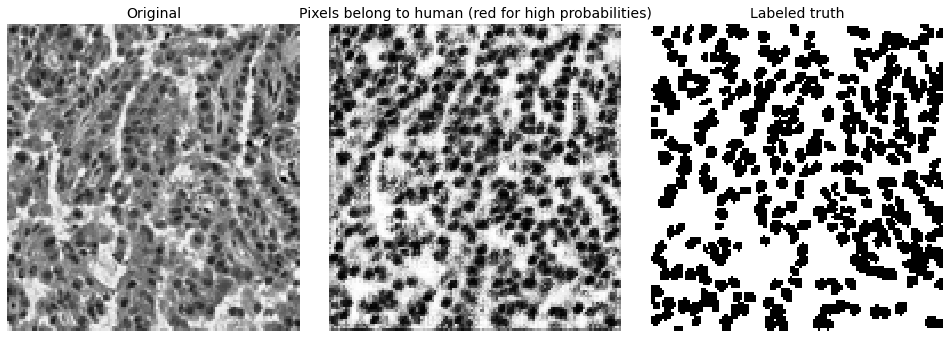

In [66]:
i_sample = 12

fig, AX = plt.subplots(1, 3, figsize=(13, (13-0.2)/3))
plt.subplots_adjust(0, 0, 1, 1, hspace=0, wspace=0.1)
for ax in AX:
    ax = ax_decorate_box(ax)
AX[0].pcolormesh(np.mean(test_input[i_sample, ...,], axis=-1), cmap=plt.cm.gray)
#AX[1].pcolormesh(y_pred[i_sample, ..., 0], cmap=plt.cm.jet)
#AX[2].pcolormesh(test_label[i_sample, ..., 0], cmap=plt.cm.jet)


AX[1].pcolormesh(y_pred[i_sample, ..., 0], cmap=plt.cm.gray)
AX[2].pcolormesh(test_label[i_sample, ..., 0], cmap=plt.cm.gray)

AX[0].set_title("Original", fontsize=14)
AX[1].set_title("Pixels belong to human (red for high probabilities)", fontsize=14)
AX[2].set_title("Labeled truth", fontsize=14)
